# CVHCI Problem 1: Skin Deetection
The implementation is based on "A skin detection approach based on the Dempster–Shafer theory of evidence"
(see http://www.sciencedirect.com/science/article/pii/S0888613X12000047)

In [2]:
%matplotlib inline

from __future__ import print_function
import glob
import itertools
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import cross_validation
from sklearn.utils.extmath import cartesian


sns.set_style('dark')
sns.set_context('talk')

ESCAPE_KEYCODE = 27
DATA_FOLDER = os.path.join(os.getcwd(), 'data')

def morph(bitmask):
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    temp = cv2.dilate(eroded,element)
    temp = cv2.subtract(img,temp)

def adjust_intensity(img, c=50):
    """Adjust the intensity dynamically. This is supposed to help with bad lightning conditions."""
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    v = hsv[..., 2]

    # divide by zero if v == 0
    with np.errstate(divide='ignore', invalid='ignore'):
        denominator = c * np.log(v)
        intensity = 2 / (1 + np.exp((-2 * v) / (denominator))) - 1
    intensity[v == 0] = 0
    intensity *= 255
    
    hsv[..., 2] = np.round(intensity)
    
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

C:\Anaconda3\envs\dempster-shafer\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
# read ground truth
# n.b. shape is same as images (480, 640, 3) uint8, NOT boolean
mask_files = glob.glob(DATA_FOLDER + '/mask-*')
masks = np.zeros((len(mask_files)), np.ndarray)
for i, f in enumerate(mask_files):
    masks[i] = cv2.imread(f)
    if masks[i] is None:
        print('Could not read', f)

# read images
data_files = [f.replace('mask-', '') for f in mask_files]
imgs = np.zeros((len(data_files)), np.ndarray)
for i, f in enumerate(data_files):
    img = cv2.imread(f)
    if img is None:
        print('Could not read', f)
    else:
        imgs[i] = img #adjust_intensity(img)

In [3]:
# SoIs for little training data
sois = [
    [lambda r, g, b: r > 99, 0.178123328, 0.3284074864],
    [lambda r, g, b: (42 < g) & (g < 181), 0.048259981, 0.0868313786],
    [lambda r, g, b: (25 < b) & (b < 150), 0.066580714, 0.1355648535],
    [lambda r, g, b: (28 < np.abs(r - g)) & (np.abs(r - g) < 83), 0.412317699, 0.6012579511],
    [lambda r, g, b: (35 < np.abs(r - b)) & (np.abs(r - b) < 136), 0.574493217, 0.6356666317],
    [lambda r, g, b: (r > g) & (r > b), 0.456460261, 0.8410131201]
]

# Sources of Interest for (non-generalized) DSSD
sois = [[lambda r, g, b: r > 140, 0.364339536, 0.524533342],
              [lambda r, g, b: (75 < g) & (g < 193), 0.147315460, 0.430099211],
              [lambda r, g, b: (43 < b) & (b < 161), 0.222264545, 0.440255872],
              [lambda r, g, b: (28 < np.abs(r - g)) & (np.abs(r - g) < 130), 0.546243640, 0.675261991],
              [lambda r, g, b: (45 < np.abs(r - b)) & (np.abs(r - b) < 187), 0.496808781, 0.673853774],
              [lambda r, g, b: (r > g) & (r > b), 0.387888000, 0.968090001]]


def classify(img):
    b, g, r = cv2.split(img)
    skin   = np.zeros((img.shape[0], img.shape[1], len(sois)))
    noskin = np.zeros((img.shape[0], img.shape[1], len(sois)))
    theta  = np.zeros((img.shape[0], img.shape[1], len(sois)))
    
    vals = np.array([
            b,
            g,
            r,
            np.abs(r-g),
            np.abs(r-b),
            (r > g) & (r > b)
        ])
    
    # Calculate mass values for all pixels for all SoIs
    for i, val in enumerate(vals):
        skin[..., i] += sois[i, 0, val]
        noskin[..., i] += sois[i, 1, val]
        theta[..., i] += sois[i, 2, val]
    
    m_skin = np.zeros(img.shape[0:2])
    m_noskin = np.zeros(img.shape[0:2])
    
    combs = set(itertools.permutations([True, False] * len(sois), len(sois)))
    # discard "all thetas" scenario
    combs.discard(tuple([True] * len(sois)))
    
    # Combine mass functions with Dempster's Rule
    for comb in combs:
        skinval = 1
        noskinval = 1
        for i, is_theta  in enumerate(comb):
            if is_theta:
                skinval *= theta[..., i]
                noskinval *= theta[..., i]
            else:
                skinval *= skin[..., i]
                noskinval *= noskin[..., i]
        m_skin += skinval
        m_noskin += noskinval

    skin_mask = (m_skin - m_noskin)#.astype(np.uint8)
    
    return skin_mask#.astype(bool)

def classify(mat):
    r, g, b = cv2.split(mat)
    skin   = np.zeros((mat.shape[0], mat.shape[1], len(sois)))
    noskin = np.zeros((mat.shape[0], mat.shape[1], len(sois)))
    theta  = np.zeros((mat.shape[0], mat.shape[1], len(sois)))
    
    # Calculate mass values for all pixels for all SoIs
    for i, soi in enumerate(sois):
        mask = soi[0](r, g, b)
        skin[..., i][mask == True] += soi[1]
        noskin[..., i][mask == False] += soi[2]
        theta[..., i][mask == True] += 1 - soi[1]
        theta[..., i][mask == False] += 1 - soi[2]
    
    m_skin = np.zeros(mat.shape[0:2])
    m_noskin = np.zeros(mat.shape[0:2])
    
    combs = set(itertools.permutations([True, False] * len(sois), len(sois)))
    # discard "all thetas" scenario
    combs.discard(tuple([True] * len(sois)))
    
    for comb in combs:
        skinval = 1
        noskinval = 1
        for i, is_theta  in enumerate(comb):
            if is_theta:
                skinval *= theta[..., i]
                noskinval *= theta[..., i]
            else:
                skinval *= skin[..., i]
                noskinval *= noskin[..., i]
        m_skin += skinval
        m_noskin += noskinval


    # normalize
    # K_skin = 0
    # K_noskin = 0
    # combs = set(itertools.permutations(['skin', 'noskin', 'theta'] * len(sois), len(sois)))
    # combs = filter(lambda p: 'skin' in p or 'noskin' in p, combs)
    # for comb in combs:
    #     normskinval = 1
    #     normnoskinval = 1
    #     for i, t in enumerate(comb):
    #         if t == 'skin':
    #             normskinval *= skinnoskin[..., i]
    #            normnoskinval *=
    #             
    #         elif t == 'noskin':
    #             
    #         elif t == 'theta':

    return m_skin * 150 > m_noskin

In [4]:
for img in imgs:
    m = np.copy(img)
    m = adjust_intensity(m, 25)
    c = classify(m)
    # Show classifier output in blue hue
    m[..., 0][c] = 255 #b
    #m[..., 1][c] = 255 #g
    m[..., 2][c] = 0 #r
    cv2.imshow('clf', m)
    if cv2.waitKey() == ESCAPE_KEYCODE:
        cv2.destroyWindow('clf')
        break

<Container object of 256 artists>

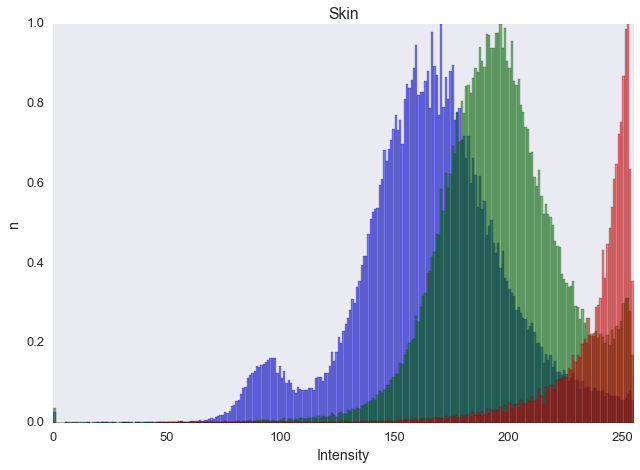

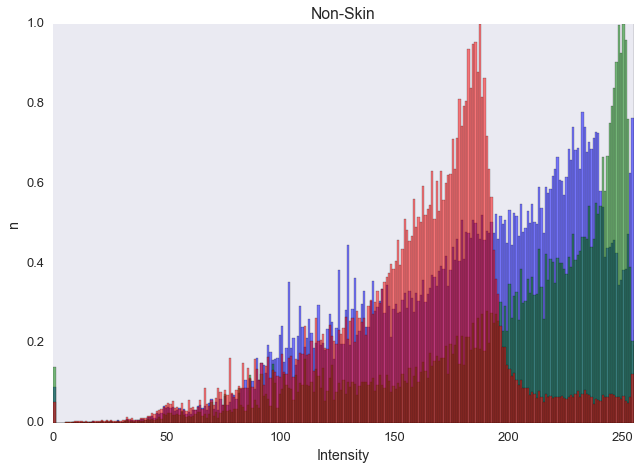

In [196]:
####
#### LEARNING PHASE
####

# normalize each channel
#all_skin /= all_skin.max(1)[:, None]
#all_nonskin /= all_nonskin.max(1)[:, None]

plt.title('Skin')
plt.xlabel('Intensity')
plt.ylabel('n')
plt.xlim([0, 255])
plt.bar(np.arange(256), all_skin[0], color='b', alpha=0.5, width=1.0)
plt.bar(np.arange(256), all_skin[1], color='g', alpha=0.5, width=1.0)
plt.bar(np.arange(256), all_skin[2], color='r', alpha=0.5, width=1.0)

plt.figure()

plt.title('Non-Skin')
plt.xlabel('Intensity')
plt.ylabel('n')
plt.xlim([0, 255])
plt.bar(np.arange(256), all_nonskin[0], color='b', alpha=0.5, width=1.0)
plt.bar(np.arange(256), all_nonskin[1], color='g', alpha=0.5, width=1.0)
plt.bar(np.arange(256), all_nonskin[2], color='r', alpha=0.5, width=1.0)

In [208]:
###
### EVALUATION
###

NUM_SOIS = 6

def preprocess(X):
    return adjust_intensity(X, (np.sqrt(np.median(X))) * 1.5)

def learn(X, y):
    global all_skin
    global all_skin_pos
    global all_nonskin
    global all_nonskin_pos
    y = y.astype(bool)
    
    # find r, g, and b skin pixels
    skin = X[y].reshape(-1, 3)
    b, g, r = skin.T
    all_skin[0] += np.bincount(b, minlength=256)
    all_skin[1] += np.bincount(g, minlength=256)
    all_skin[2] += np.bincount(r, minlength=256)
    all_skin[3] += np.bincount(np.abs(r - g), minlength=256)
    all_skin[4] += np.bincount(np.abs(r - b), minlength=256)
    all_skin[5] += np.bincount((r > g) & (r > b), minlength=256)
    #all_skin_pos += y[...,0].flatten()
    
    # same with non-skin pixels
    nonskin = X[~y].reshape(-1, 3)
    b, g, r = nonskin.T
    all_nonskin[0] += np.bincount(b, minlength=256)
    all_nonskin[1] += np.bincount(g, minlength=256)
    all_nonskin[2] += np.bincount(r, minlength=256)
    all_nonskin[3] += np.bincount(np.abs(r - g), minlength=256)
    all_nonskin[4] += np.bincount(np.abs(r - b), minlength=256)
    all_nonskin[5] += np.bincount((r > g) & (r > b), minlength=256)
    #all_nonskin_pos += ~y[...,0].flatten()
    
def finish_learn():
    """Calculate mass values for the 6 criteria we got."""
    global all_skin
    global all_skin_pos
    global all_nonskin
    global all_nonskin_pos
    
    # Scale each channel to [0, 1].
    all_skin /= all_skin.max(1)[:, None]
    #all_skin_pos /= all_skin_pos.max()
    all_nonskin /= all_nonskin.max(1)[:, None]
    #all_nonskin_pos /= all_nonskin_pos.max()

    raw_sois = np.stack((all_skin, all_nonskin), 1)

    for i in range(NUM_SOIS):
        # number of skin pixels/ number of non-skin pixels
        ns = all_skin[i]
        nns = all_nonskin[i]
        # ns and nns are TP and FP (or, FN and TN), respectively.
        mass = (ns - nns) / (ns + nns)
        skin, noskin, theta = sois[i]
        #sois[i, 0, :] = ? skin    where mass is positive: mass else: 0.
        skin[mass > 0] = mass[mass > 0]
        #sois[i, 1, :] = ? nonskin where mass is positive: 0    else: -mass.
        noskin[mass < 0] = -mass[mass < 0]
        #sois[i, 2, :] = ? theta   where mass is positive: mass else: -mass.
        theta[mass > 0] =  1 - mass[mass > 0]
        theta[mass < 0] =  1 - -mass[mass < 0]

def classify(img):
    b, g, r = cv2.split(img)
    skin   = np.zeros((img.shape[0], img.shape[1], len(sois)))
    noskin = np.zeros((img.shape[0], img.shape[1], len(sois)))
    theta  = np.zeros((img.shape[0], img.shape[1], len(sois)))
    blub = np.zeros_like(r)
    blub[((r > g) & (r > b))] = 1
    
    vals = np.array([
            b,
            g,
            r,
            np.abs(r-g),
            np.abs(r-b),
            (r > g) & (r > b)
        ])
    
    # Calculate mass values for all pixels for all SoIs
    for i, val in enumerate(vals):
        skin[..., i] += sois[i, 0, val]
        noskin[..., i] += sois[i, 1, val]
        theta[..., i] += sois[i, 2, val]
    
    m_skin = np.zeros(img.shape[0:2])
    m_noskin = np.zeros(img.shape[0:2])
    
    combs = set(itertools.permutations([True, False] * len(sois), len(sois)))
    # discard "all thetas" scenario
    combs.discard(tuple([True] * len(sois)))
    
    # Combine mass functions with Dempster's Rule
    for comb in combs:
        skinval = 1
        noskinval = 1
        for i, is_theta  in enumerate(comb):
            if is_theta:
                skinval *= theta[..., i]
                noskinval *= theta[..., i]
            else:
                skinval *= skin[..., i]
                noskinval *= noskin[..., i]
        m_skin += skinval
        m_noskin += noskinval

    skin_mask = (m_skin - m_noskin)#.astype(np.uint8)
    
    return skin_mask#.astype(bool)

# These are histograms for the r, g, and b-values of skin and non-skin.
all_skin = np.zeros([NUM_SOIS, 256])
#all_skin_pos = np.zeros(640 * 480)
all_nonskin = np.zeros([NUM_SOIS, 256])
#all_nonskin_pos = np.zeros(640 * 480)
# 5 (6) SoIs, 256 possible criterion-values,
# 3 mass values for skin, noskin, theta
sois = np.zeros([NUM_SOIS, 3, 256])
#sois_pos = np.zeros(640 * 480)

X_train, X_test, y_train, y_test = cross_validation.train_test_split(imgs, masks, test_size=0.1)

c = 5
print('Learning on', X_train.size, 'images', end='')
for X, y in zip(X_train, y_train):
    X = preprocess(X)
    learn(X, y)
    print('.', end='')
print('done!')

finish_learn()

tp = fp = tn = fn = 0.0
for X, y in zip(X_test, y_test):
    X = preprocess(X)
    clf = classify(X)#.astype(np.uint8)
    
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    
    clf = cv2.morphologyEx(clf, cv2.MORPH_OPEN, kernel).reshape(480, 640)
    
    #y2 = y[..., 0]
    #tp += np.count_nonzero(clf & y2)
    #fp += np.count_nonzero(clf & ~y2)
    #tn += np.count_nonzero(~clf & ~y2)
    #fn += np.count_nonzero(~clf & y2)
    
    # visualize
    m = np.copy(y)
    m[..., 2][clf < 0] = clf[clf < 0] * 255
    m[..., 1][clf > 0] = clf[clf > 0] * 255
    m[..., 0] /= 0
    cv2.imshow('Picture -- Truth -- Classification Result', np.hstack([X, m]))
    
    if cv2.waitKey() == ESCAPE_KEYCODE:
        break

cv2.destroyWindow('Picture -- Truth -- Classification Result')

p = tp + fp
n = tn + fn
tp = tp / p
fp = fp / p
tn = tn / n
fn = fn / n
print('TP:', tp, '%')
print('FP:', fp, '%')
print('TN:', tn, '%')
print('FN:', fn, '%')
print('F1-Score:', (2 * tp) / (2 * tp + fn + fp))

Learning on 38 images......................................done!


ZeroDivisionError: float division by zero

In [6]:
qtconsole

In [289]:
def hist(X, title='Histogram', colors=list('bgrkw'), xlabel='Intensity', ylabel='n', linewidth=2):
    if not len(X.shape) > 1:
        X = np.array([X])
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim([0, 255])
    
    for x, c in zip(X, colors):
        plt.plot(x, color=c, linewidth=linewidth)
        #plt.bar(np.arange(256), x, color=c, alpha=0.5, width=1.0)

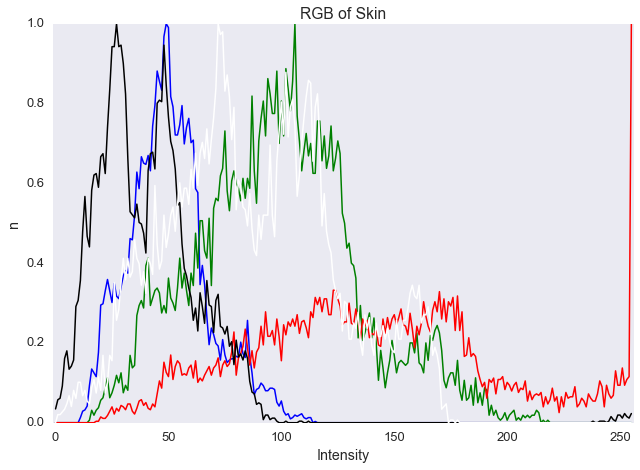

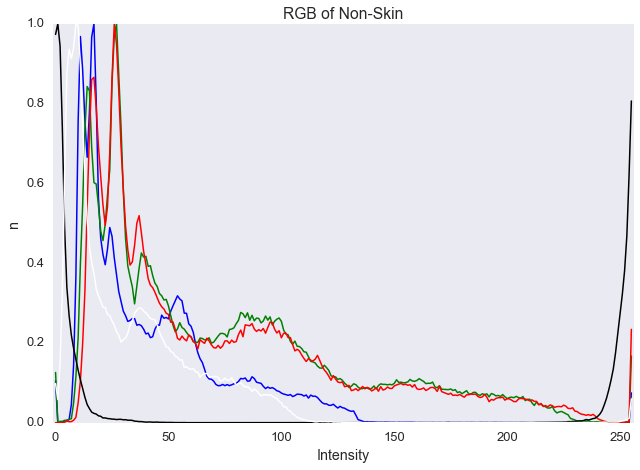

In [68]:
plt.title('RGB of Skin')
plt.xlabel('Intensity')
plt.ylabel('n')
plt.xlim([-1, 256])
for y, c in zip(all_skin, 'bgrkw'):
    plt.plot(y, color=c, linewidth=1.5)

plt.figure()

plt.title('RGB of Non-Skin')
plt.xlabel('Intensity')
plt.ylabel('n')
plt.xlim([-1, 256])
for y, c in zip(all_nonskin, 'bgrkw'):
    plt.plot(y, color=c, linewidth=1.5)